In [1]:
# Install dependecies
# !pip install -q datasets transformers
# !pip install accelerate
!pip install -U pip wheel
!pip install ensemble-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/5b/0b/e45d26ccd28568013523e04f325432ea88a442b4e3020b757cf4361f0120/transformers-4.30.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 10.1 MB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.14.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
# Load the Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Run this cell to avoid any error in ensemble-transformer library
# After running it, please restart the kernel
import shutil
import os

src_path = '/content/drive/MyDrive/Resource/config.py'
dst_path = '/usr/local/lib/python3.10/dist-packages/ensemble_transformers'
os.remove(dst_path + '/config.py')
shutil.copy(src_path, dst_path)

'/usr/local/lib/python3.10/dist-packages/ensemble_transformers/config.py'

In [9]:
# Dataset labels id, ,
id2label = { 'benign': 0, 'malignant':1}

In [5]:
from ensemble_transformers import EnsembleModelForImageClassification
# Load the models
# pre-trained model checkpoint to be used for fine-tuning
model_names = ["ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-BreastCancer-BreakHis-AH-60-20-20" ,
               "ALM-AHME/convnextv2-large-1k-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20",
               "ALM-AHME/beit-large-patch16-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20"]

ensemble = EnsembleModelForImageClassification.from_multiple_pretrained(*model_names)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


In [6]:
#load libraries
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
# from transformers import AutoImageProcessor
# from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from ensemble_transformers import EnsembleModelForImageClassification
import torch
from PIL import Image
import time

In [7]:
# Load the model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble.to(device)
# im = im.to(device)

In [53]:
img_path = '/content/drive/MyDrive/Breast_Cancer/Dataset-Resized/test/'

# Target list is the ground truth labels
target_list = []
# Prediction list is the predicted labels
pred_list = []


# get the start time
start_time = time.time()

# Confidence score for each individual model
#confidences = torch.tensor([0.99, 0.976, 0.985])
confidences = torch.tensor([1.5, 1.1 ,1.45])


# Normalize the confidence scores
normalized_weights = confidences / torch.sum(confidences)
# normalized_weights = torch.tensor([0.2, 0.5, 0.3])



for foldername in os.listdir(img_path):
    # print(foldername)
    for filename in os.listdir(img_path + foldername):
        im = Image.open(img_path + foldername + "/" + filename)
        # Empty tensor array to store the ensembled results
        ensemble_predictions = torch.zeros(len(id2label))
        with torch.no_grad():
            logits  = ensemble(im).logits
            # print(logits)
            i = 0     # Variable to iterate weigths array
            for logit in logits:
              ensemble_predictions += (logit.to('cpu') * normalized_weights[i])[0]
              i += 1
            predicted_label = ensemble_predictions.argmax(-1).item()
            # print("Predicted Label: " , predicted_label)

        target_list.append(id2label[foldername])
        pred_list.append(predicted_label)
        # break
    # break
    print("Target: " , target_list)
    print("Predicted: " , pred_list)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

Target:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Visualize Results

In [11]:

#!pip install wandb

#load libraries
import matplotlib.pyplot as plt
import numpy as np
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import warnings

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [54]:
# Make a copy of each prediction list
target_list_copy = target_list
pred_list_copy = pred_list

<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

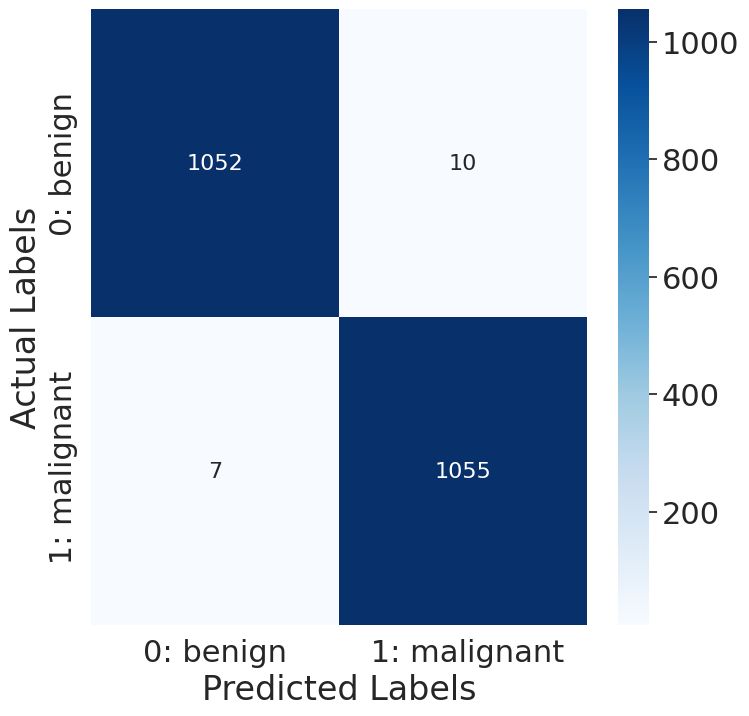

In [55]:
# test_pred_labels=pred_list_copy.argmax(axis=1)
# Plot Confusion Matrix

data = confusion_matrix(target_list_copy,pred_list_copy,labels=[0,1])
df_cm = pd.DataFrame(data, columns=['0: benign',' 1: malignant'], index = ['0: benign',' 1: malignant'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [56]:
# Classification report
print(classification_report(target_list_copy,pred_list_copy,digits=3))

              precision    recall  f1-score   support

           0      0.993     0.991     0.992      1062
           1      0.991     0.993     0.992      1062

    accuracy                          0.992      2124
   macro avg      0.992     0.992     0.992      2124
weighted avg      0.992     0.992     0.992      2124



In [57]:
# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,3)],
            "macro_precision": [round(precision,3)],
            "macro_recall": [round(recall,3)],
            "macro_f1": [round(f1,3)],
            "weighted_precision": [round(weighted_precision,3)],
            "weighted_recall": [round(weighted_recall,3)],
            "weighted_f1": [round(weighted_f1,3)]
            }
    return pd.DataFrame.from_dict(results)

In [58]:
beit_test_result=evaluation_summary("Ensemble-Transformer-Classification-Test-data", pred_list_copy , target_list_copy)

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,Ensemble-Transformer-Classification-Test-data,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000
